In [369]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


import math
import numpy as np

import pandas as pd


import asyncio
import concurrent.futures

import predict

In [370]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

# Dados de exemplo de tempo (t)
global PREDICT_TYPE
PREDICT_TYPE = 'MONTH' #'DAY':'WEEK':'MONTH':'YEAR'
A = 168 

t = np.linspace(0, A - 1, A)
print(len(t))

# Parâmetros da curva logística
P0 = 5  # Transações inicial
K = 10000  # Valor máximo transações estimado
r =  0.09 # Taxa de crescimento
t0 = A / 3     # Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística
global rate_transactions
AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)



168


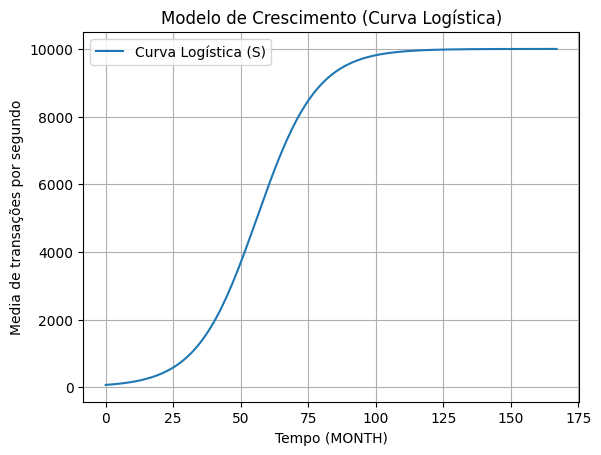

In [371]:
# Plotagem da curva logística
plt.plot(t, AVG_RATE_TRANSACTIONS, label='Curva Logística (S)')
plt.xlabel(f'Tempo ({PREDICT_TYPE})')
plt.ylabel('Media de transações por segundo')
plt.title('Modelo de Crescimento (Curva Logística)')
plt.legend()
plt.grid(True)
plt.show()

In [372]:

def expand_transations_by_period(predict_type, rate_transations_per_second):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY,
    'WEEK': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 365
    }[predict_type](rate_transations_per_second)

total_transactions_by_period = expand_transations_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

In [373]:
ENDORSEMENT_POLICY = 1/2
endorsement_transations = total_transactions_by_period * ENDORSEMENT_POLICY

# Storage e Transações

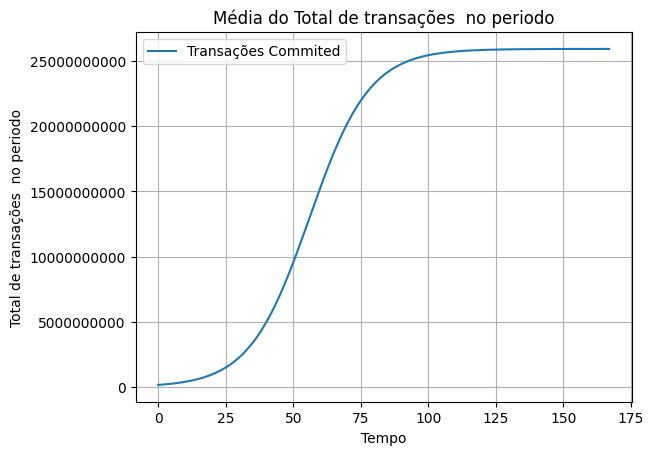

In [374]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(t, total_transactions_by_period, label='Transações Commited')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de transações  no periodo')
plt.title('Média do Total de transações  no periodo')
plt.legend()
plt.show()

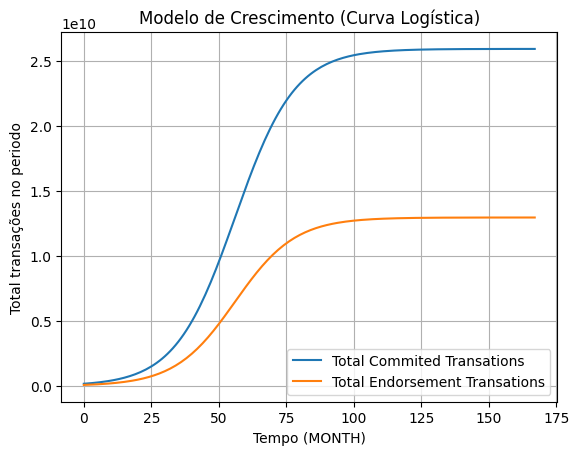

In [375]:
fig, ax = plt.subplots()

ax.plot(t, total_transactions_by_period, label='Total Commited Transations')
ax.plot(t, endorsement_transations, label='Total Endorsement Transations')
plt.xlabel(f'Tempo ({PREDICT_TYPE})')
plt.ylabel('Total transações no periodo')
plt.title('Modelo de Crescimento (Curva Logística)')
plt.legend()
plt.grid(True)
plt.show()

In [376]:

blockchain_predict = predict.blockchain_predict()


def estimate_blocks(blockchain_predict, avg_tps, total_transations_period):
    total_blocks = None
    batch_type  = ""
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = blockchain_predict.max_message_count  / avg_tps

    #Quantas transações eu preciso para fechar um bloco para max_bytes
    aggregate_total_transations_if_batch_max_bytes = blockchain_predict.absolute_max_bytes / blockchain_predict.transation_size
    time_to_batch_bytes  = aggregate_total_transations_if_batch_max_bytes / avg_tps
    total_blocks = None
    if time_to_batch_messages >= blockchain_predict.batch_timeout and \
        time_to_batch_bytes >=  blockchain_predict.batch_timeout:

        #calcular por batchtimeout
        aggregate_total_transations_if_batch_timeout = blockchain_predict.batch_timeout * avg_tps
        total_blocks = total_transations_period / aggregate_total_transations_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes:
        total_blocks = total_transations_period / time_to_batch_messages
        batch_type = "batch_message"
        #batch messages
    
    elif time_to_batch_bytes    < time_to_batch_messages:
        total_blocks = total_transations_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        #batch bytes
    else:
        raise Exception
        
    
    return total_blocks, batch_type

StorageDemand = []


for i_period in range(0,A):
    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    total_transations_by_period = total_transactions_by_period[i_period]
    print(avg_t)
    print(total_transations_by_period)

    i_storage_demand = predict.StorageDemand()
    i_storage_demand.period                       = i_period    
    i_storage_demand.total_transactions           = total_transations_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type                 = estimate_blocks(blockchain_predict, avg_t, total_transations_by_period)
    i_storage_demand.calculated_total_size_blocks = (i_storage_demand.total_blocks * blockchain_predict.calculate_block_headers_size()) + (i_storage_demand.total_transactions * blockchain_predict.transation_size)
    
    StorageDemand.append(i_storage_demand)
    


69.28892412685175
179596891.33679977
75.30070361417663
195179423.7679458
81.87030443567583
212207829.09727177
89.04863531929998
230814062.74762556
96.8910851460445
251141692.69854736
105.45788476532019
273346837.31170994
114.81449159277884
297599162.20848274
125.03199707772423
324082936.42546123
136.18755677934246
352998147.17205566
148.36484235456356
384561671.38302875
161.65451422015545
419008500.85864294
176.15471299069873
456593016.0718911
191.97156699377425
497590301.64786285
209.21971220395997
542297494.0326643
228.02281979682724
591035148.9133761
248.5141251812021
644148612.4696759
270.83695080077433
702009376.4756072
295.145213184226
765016392.5735137
321.60390264866874
833597315.6653494
350.3895217113337
908209640.275777
381.6904656335163
989341686.9220743
415.7073256136478
1077513387.990575
452.65309198261843
1173276814.418947
492.75323137300603
1277216375.7188318
536.245608298647
1389948616.7100928
583.3802179872283
1512121525.0228958
634.4186937896801
1644413254.302851
689.

In [377]:
for s in StorageDemand:
    atributos = vars(s)
    # Iterando sobre o dicionário e imprimindo os atributos
    for chave, valor in atributos.items():
        print(f"{chave}: {valor}")

total_blocks: 1443099.5615711987
total_transactions: 179596891.33679977
calculated_total_size_blocks: 218666894981.37018
batch_type: batch_bytes
period: 0
total_blocks: 1704381.1698851408
total_transactions: 195179423.7679458
calculated_total_size_blocks: 237665420486.44003
batch_type: batch_bytes
period: 1
total_blocks: 2014751.4151899577
total_transactions: 212207829.09727177
calculated_total_size_blocks: 258431552453.99893
batch_type: batch_bytes
period: 2
total_blocks: 2383544.120504195
total_transactions: 230814062.74762556
calculated_total_size_blocks: 281127540772.24945
batch_type: batch_bytes
period: 3
total_blocks: 2821865.426565901
total_transactions: 251141692.69854736
calculated_total_size_blocks: 305930096483.3342
batch_type: batch_bytes
period: 4
total_blocks: 3342926.0628264016
total_transactions: 273346837.31170994
calculated_total_size_blocks: 333031595975.102
batch_type: batch_bytes
period: 5
total_blocks: 3962434.2873576265
total_transactions: 297599162.20848274
calc

In [378]:
i_period           = np.array([s.period for s in StorageDemand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in StorageDemand]) )

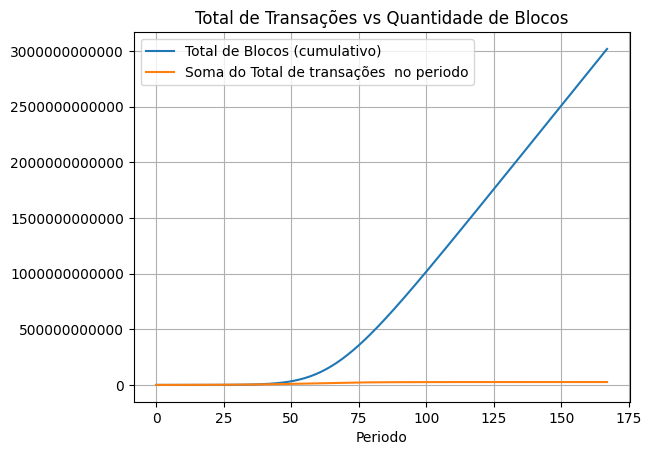

In [379]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(i_period, cumulative_blocks, label='Total de Blocos (cumulativo)')

ax.plot(t, total_transactions_by_period, label='Soma do Total de transações  no periodo')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('')
plt.title('Total de Transações vs Quantidade de Blocos')
plt.legend()
plt.show()

In [380]:
BYTE_TO_GIGA =  1024 * 1024 * 1024
cumulative_size_GB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in StorageDemand]) /  BYTE_TO_GIGA )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


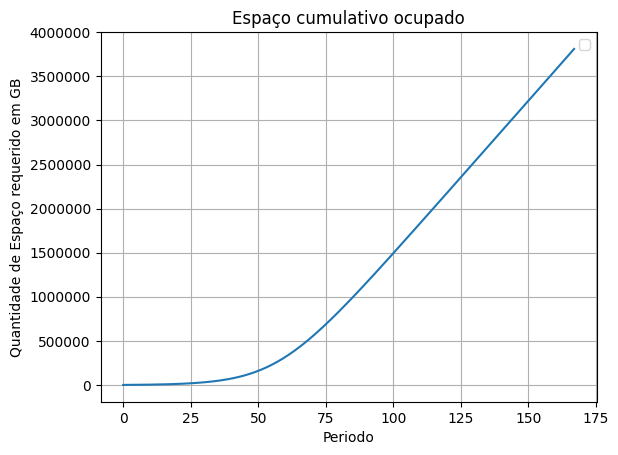

In [381]:
fig, ax = plt.subplots()
ax.plot(i_period, cumulative_size_GB, label='')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('Quantidade de Espaço requerido em GB')
plt.title('Espaço cumulativo ocupado')
plt.legend()
plt.show()

# CPU

Analise conforme TPS

## CPU Ordering Service

In [382]:
aggregate_total_required_vcpu_osn = np.array([])
vCPU_BASE     =  1
vCPU_BASE_TPS = 150 # 2vcpu = 200

ordering_transations = AVG_RATE_TRANSACTIONS

for tps in ordering_transations:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_osn = np.append(aggregate_total_required_vcpu_osn, target_required_vcpu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


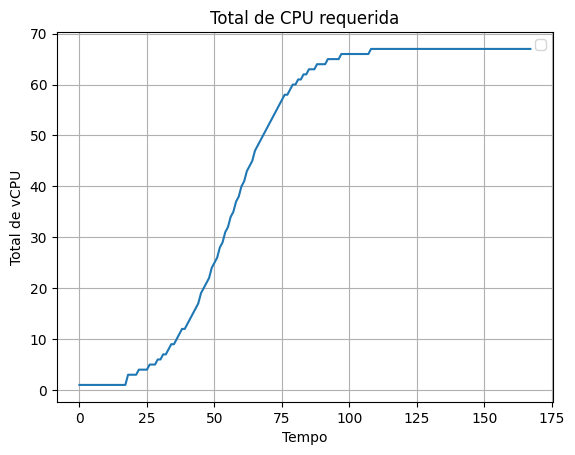

In [383]:
#
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu_osn, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

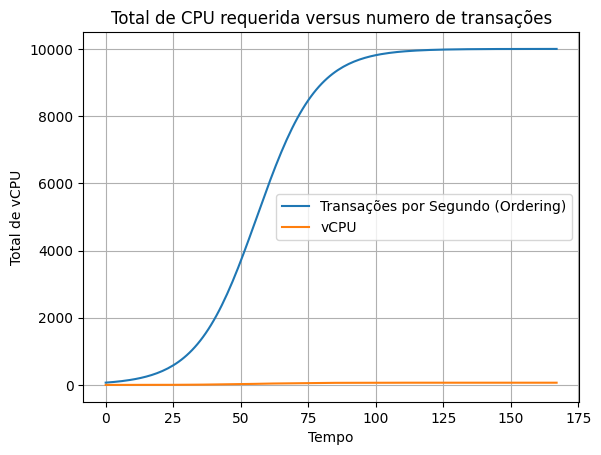

In [384]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()

plt.plot(t, ordering_transations, label='Transações por Segundo (Ordering)')
plt.plot(t, aggregate_total_required_vcpu_osn, label='vCPU')


ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida versus numero de transações')
plt.legend()
plt.show()

## CPU PEER

In [385]:
aggregate_total_required_vcpu_peer = np.array([])
vCPU_BASE     =  2
vCPU_BASE_TPS = 200 # 2vcpu = 200

peer_commited_transations = AVG_RATE_TRANSACTIONS
peer_endorsement_transations = AVG_RATE_TRANSACTIONS * ENDORSEMENT_POLICY
peer_endorsement_commited_transations = peer_commited_transations + peer_endorsement_transations

for tps in peer_endorsement_commited_transations:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_peer = np.append(aggregate_total_required_vcpu_peer, target_required_vcpu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


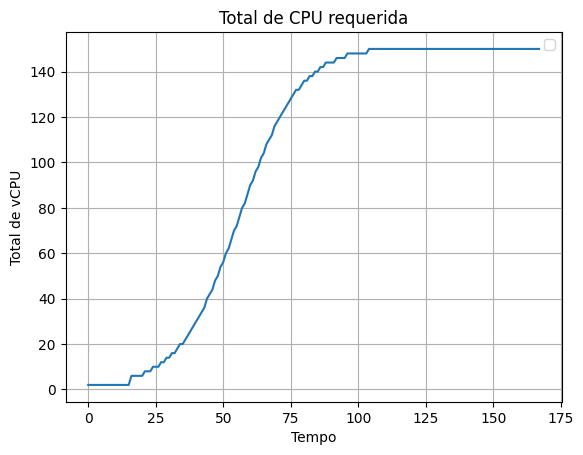

In [386]:
#
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu_peer, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

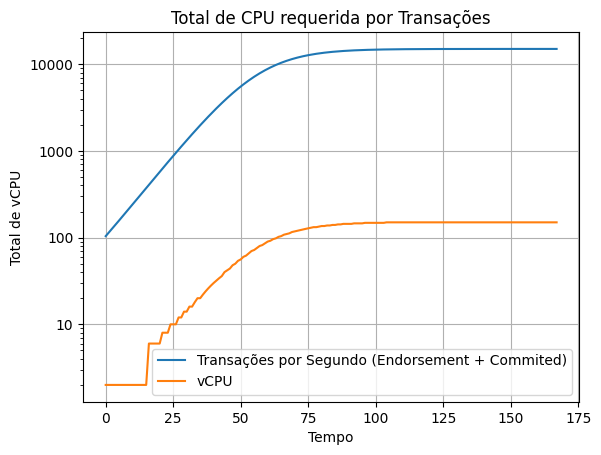

In [387]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()

plt.semilogy(t, peer_endorsement_commited_transations, label='Transações por Segundo (Endorsement + Commited)')
plt.plot(t, aggregate_total_required_vcpu_peer, label='vCPU')


ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida por Transações')
plt.legend()
plt.show()

# Cloud Costs

In [388]:
df = pd.read_csv('Amazon EC2 Instance Comparison.csv')
df['vCPUs'] = df['vCPUs'].str.replace(r'\D+', '', regex=True)
df['On Demand'] = df['On Demand'].str.replace(r'[^0-9.]', '', regex=True)

df['vCPUs'] = pd.to_numeric(df['vCPUs'])
df['On Demand'] = pd.to_numeric(df['On Demand'])

#instancias = df[(df['vCPUs'] > aggregate_total_required_vcpu_peer)]

In [389]:
df

,Name,API Name,Instance Memory,vCPUs,Instance Storage,Network Performance,On Demand,Linux Reserved cost,Linux Spot Minimum cost,Windows On Demand cost,Windows Reserved cost
0,C6A Large,c6a.large,4.0 GiB,2,EBS only,Up to 12.5 Gigabit,0.0765,$0.0506 hourly,$0.0388 hourly,$0.1685 hourly,$0.1426 hourly
1,C6A Extra Large,c6a.xlarge,8.0 GiB,4,EBS only,Up to 12.5 Gigabit,0.1530,$0.1012 hourly,$0.0769 hourly,$0.3370 hourly,$0.2852 hourly
2,C6A Double Extra Large,c6a.2xlarge,16.0 GiB,8,EBS only,Up to 12.5 Gigabit,0.3060,$0.2024 hourly,$0.1520 hourly,$0.6740 hourly,$0.5704 hourly
3,C6A Quadruple Extra Large,c6a.4xlarge,32.0 GiB,16,EBS only,Up to 12.5 Gigabit,0.6120,$0.4048 hourly,$0.3186 hourly,$1.3480 hourly,$1.1408 hourly
4,C6A Eight Extra Large,c6a.8xlarge,64.0 GiB,32,EBS only,12.5 Gigabit,1.2240,$0.8097 hourly,$0.6129 hourly,$2.6960 hourly,$2.2817 hourly
5,C6A 12xlarge,c6a.12xlarge,96.0 GiB,48,EBS only,18.75 Gigabit,1.8360,$1.2145 hourly,$0.8785 hourly,$4.0440 hourly,$3.4225 hourly
6,C6A 16xlarge,c6a.16xlarge,128.0 GiB,64,EBS only,25 Gigabit,2.4480,$1.6194 hourly,$1.1709 hourly,$5.3920 hourly,$4.5633 hourly
7,C6A 24xlarge,c6a.24xlarge,192.0 GiB,96,EBS only,37.5 Gigabit,3.6720,$2.4290 hourly,$1.6719 hourly,$8.0880 hourly,$6.8450 hourly
8,C6A 32xlarge,c6a.32xlarge,256.0 GiB,128,EBS only,50 Gigabit,4.8960,$3.2387 hourly,$2.2912 hourly,$10.7840 hourly,$9.1267 hourly
9,C6A 48xlarge,c6a.48xlarge,384.0 GiB,192,EBS only,50 Gigabit,7.3440,$4.8581 hourly,$3.3435 hourly,$16.1760 hourly,$13.6901 hourly


In [390]:
def provisioned_instance_types(required_vcpu):
    provisioned_vcpu = np.array([])

    # Iterar sobre os elementos do array
    for vcpu in required_vcpu:
        # Verificar se o valor existe na coluna do DataFrame
        if vcpu in df['vCPUs'].values:
            # Se existir, adiciona o valor ao novo array
            type = df[(df['vCPUs'] == vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, type)
        else:
            # Se não existir, pega o valor mais próximo na coluna do DataFrame
            next_type = df[(df['vCPUs'] > vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, next_type)

    return provisioned_vcpu

In [391]:
provisioned_instance_peer = provisioned_instance_types(aggregate_total_required_vcpu_peer)
provisioned_instance_osn = provisioned_instance_types(aggregate_total_required_vcpu_osn)

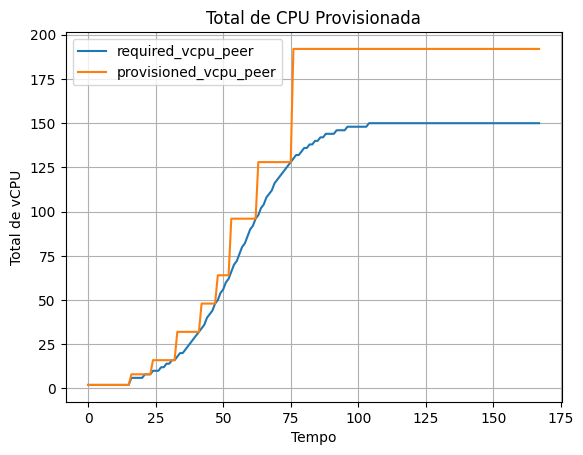

In [392]:
fig, ax = plt.subplots()

ax.plot(t, aggregate_total_required_vcpu_peer, label='required_vcpu_peer')

plot_provisioned_instance_peer = [x['vCPUs'] for x in provisioned_instance_peer]

ax.plot(t, plot_provisioned_instance_peer, label='provisioned_vcpu_peer')


ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU Provisionada')
plt.legend()
plt.show()

In [393]:
def convert_period_hours(predict_type):
    DAY_HOUR  = 24
    return {
    'DAY': DAY_HOUR,
    'WEEK': 7 * DAY_HOUR,
    'MONTH': 730, # Providers consideram 730 por mes
    'YEAR': 365 * DAY_HOUR
    }[predict_type]

period_hours = convert_period_hours(PREDICT_TYPE)

cost_provisioned_instance_peer =  np.array([x['On Demand'] for x in provisioned_instance_peer])

computer_cost_period_peer = cost_provisioned_instance_peer * period_hours


In [394]:
computer_cost_period_peer


array([  55.845,   55.845,   55.845,   55.845,   55.845,   55.845,
         55.845,   55.845,   55.845,   55.845,   55.845,   55.845,
         55.845,   55.845,   55.845,   55.845,  223.38 ,  223.38 ,
        223.38 ,  223.38 ,  223.38 ,  223.38 ,  223.38 ,  223.38 ,
        446.76 ,  446.76 ,  446.76 ,  446.76 ,  446.76 ,  446.76 ,
        446.76 ,  446.76 ,  446.76 ,  893.52 ,  893.52 ,  893.52 ,
        893.52 ,  893.52 ,  893.52 ,  893.52 ,  893.52 ,  893.52 ,
       1340.28 , 1340.28 , 1340.28 , 1340.28 , 1340.28 , 1340.28 ,
       1787.04 , 1787.04 , 1787.04 , 1787.04 , 1787.04 , 2680.56 ,
       2680.56 , 2680.56 , 2680.56 , 2680.56 , 2680.56 , 2680.56 ,
       2680.56 , 2680.56 , 2680.56 , 3574.08 , 3574.08 , 3574.08 ,
       3574.08 , 3574.08 , 3574.08 , 3574.08 , 3574.08 , 3574.08 ,
       3574.08 , 3574.08 , 3574.08 , 3574.08 , 5361.12 , 5361.12 ,
       5361.12 , 5361.12 , 5361.12 , 5361.12 , 5361.12 , 5361.12 ,
       5361.12 , 5361.12 , 5361.12 , 5361.12 , 5361.12 , 5361.

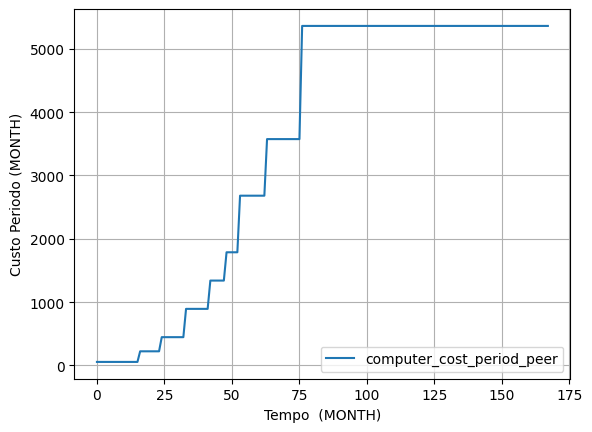

In [395]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, computer_cost_period_peer, label='computer_cost_period_peer')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()